## -----------------------------------------------------------------
# AI & ML - Coursework 2 - 1st diet
## Student Name: Akama Emmanuel Ovokerie
## Student ID: S2229758

ATTESTATION: I confirm that the material contained within the submitted coursework is all my own work 
## -----------------------------------------------------------------

# 1. Introduction and problem definition
#### Natural Language Processing (NLP): Classification of News Articles
Text classification algorithms are at the heart of a variety of software systems that process text data at scale. This does not come as a surprise since text data is one of the most common types of data that individuals and organisations use and/or process today, but because it doesn't have a clear structure, it can be difficult and time-consuming to extract insights from them. For example, modern AI-powered email softwares uses text classification to determine whether incoming mail is sent to the inbox or filtered into the spam folder. Similarly, discussion forums use text classification to determine whether comments should be flagged as inappropriate.

This coursework extends the work done in Lab 8, using the content of news articles to classify them into one of the 4 following categories: `World, Sports, Business, Sci/Tech`.

In the report contained in this coursework, we will enumerate steps to create a text classification model to classify the news articles into their respective categories.

In Lab 8, three (3) methods were used to create the model: a k-nearest neighbours classifier, a simple neural network,  and a recurrent neural network. We will expand on the work done in the lab (with additions, where necessary)

The workflow we would adopt for this report is as follows:
1. Preprocess the text
2. Vectorize the text 
3. Create models for NLP
4. Train the models
5. Make predictions
6. Evaluate the models
 

The workflow aligns closely to the ML pipeline that was discussed in the lectures.

### Module Imports
To execute the tasks contained in this report, we need to import relevant *Python* modules. Since it is considered a good practice to import modules at the top of the notebook file, we shall do so here, rather than spread it throughout the whole file. This way a single look will inform of all the required modules to execute all code cells from one single cell.

In [17]:
# import python libraries
import re, nltk, tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.layers import TextVectorization, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# download nltk resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Preparation 
The first step to data preparation is data ingestion. This process consist of moving the data from a source into a landing area or an object store where it can be used for ad hoc queries and analytics. A simple data ingestion pipeline consumes data from a point of origin, cleans it up a bit, then writes it to a destination. 

In [2]:
# load the data 
train_data = pd.read_csv('C:/Users/emman/OneDrive - GLASGOW CALEDONIAN UNIVERSITY/Documents/GCU/Module - AI & ML/Assessments/CW 02/Dataset/news_dataset/train.csv')
test_data = pd.read_csv('C:/Users/emman/OneDrive - GLASGOW CALEDONIAN UNIVERSITY/Documents/GCU/Module - AI & ML/Assessments/CW 02/Dataset/news_dataset/test.csv')

As we're peforming an overview of the data, let's review the data structure, and observe a listing of few data samples.

In [3]:
# check the structure
print(train_data.shape, test_data.shape)

(120000, 3) (7600, 3)


In [4]:
# preview the data
print(train_data.head(5), test_data.head(5))

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...      Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4      Ky. Company Wins Grant to St

Now that we have an idea of how the data looks like, let's check if we have unique and corresponding target labels in the train and test datasets

In [5]:
# confirm unique target labels
print('Unique train target labels :', train_data['Class Index'].unique())
print('Unique test target labels :', test_data['Class Index'].unique())

Unique train target labels : [3 4 2 1]
Unique test target labels : [3 4 2 1]


We have confirmed that the data has unique target labels. Next, we will re-index the `Class Index` column to start from zero so it's easier to work with later on. Afterwards, we use the `Class Index` column to feature engineer a listing of target indexes with the matching category names. This step is necessary since it is easier for the ML algorithm to work with numeric labels, but for us humans it is easier to work with text labels. Note, with this, `0` - 'World', `1` - 'Sports', `2` - 'Business', and `3` - 'Sci/Tech'.

In [6]:
# substract 1 to re-index from zero
train_data['Class Index'] = train_data['Class Index'] - 1
test_data['Class Index'] = test_data['Class Index'] - 1

# create a label listing with matching category names
label_names = ['World', 'Sports', 'Business', 'Sci/Tech'] 

Also, we will drop the `Title` column since the `Description` column has more text to classify each news category.

In [7]:
# drop irrelevant column
train_data = train_data.drop(columns=['Title'], axis=1)
test_data = test_data.drop(columns=['Title'], axis=1)

# check the shape
print(train_data.shape, test_data.shape)

(120000, 2) (7600, 2)


### Text Visualization
Word clouds can be used to visualize the most frequent words in the dataset. They also can be used to get a better understanding of this data. In a word cloud, the ,size of the word is proportional to the frequency of the word, meaning the more frequent the word, the bigger the word.

The code cell below contain a utility function to creates a word cloud text visualization.

In [8]:
# CODE from Lab 8: function to create text visualization (limit to 1000 words)
def create_word_cloud(string):
    count = len(string) 
    if count > 0:
        print("Word count: ", count)
        wordcloud = WordCloud(
            width=1400,
            height=700,
            background_color="white",
            max_words=1000,
            min_font_size=10,
        ).generate(string)
        plt.figure(figsize=(18, 10), facecolor=None)
        plt.imshow(wordcloud)
    else:
        print("Word count: ", count)

Next, let's create a descriptive words for each class (using the training and  datasets), so we can visualize their usage frequency.

In [9]:
# create a list of descriptive words for each class (using the train dataset)
world_news = " ".join(train_data[train_data['Class Index'] == 0]['Description'])
sports_news = " ".join(train_data[train_data['Class Index'] == 1]['Description'])
business_news = " ".join(train_data[train_data['Class Index'] == 2]['Description'])
science_news = " ".join(train_data[train_data['Class Index'] == 3]['Description'])

Word count:  5906405
Word count:  5583931
Word count:  5990707
Word count:  5845575


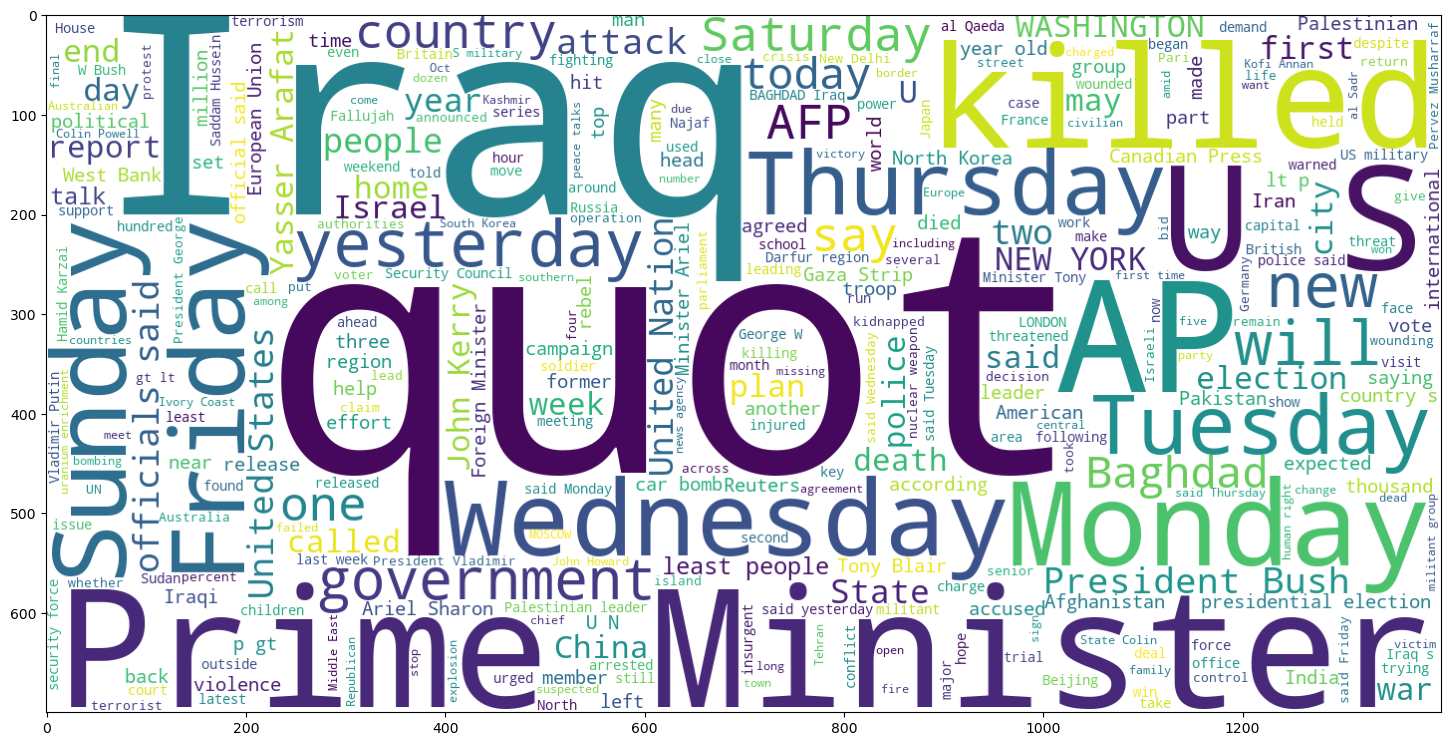

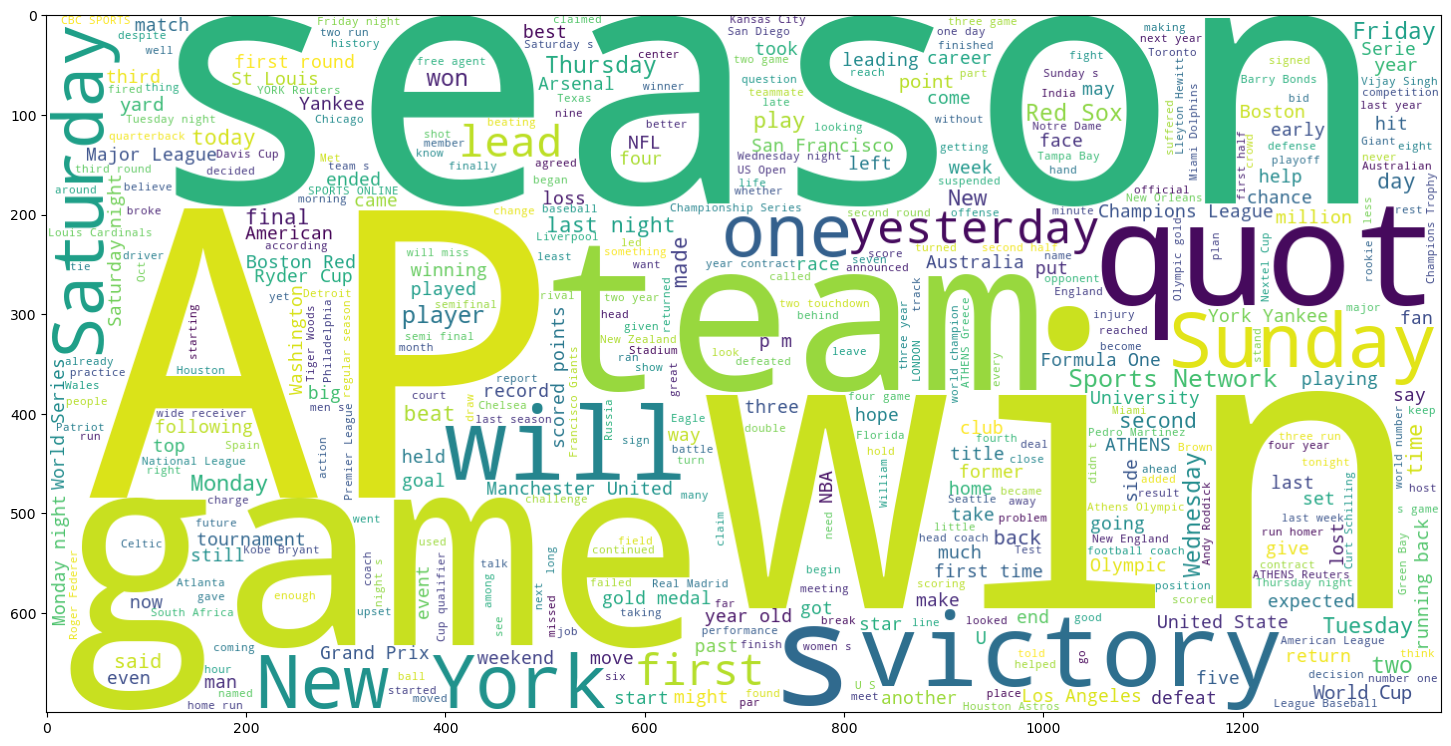

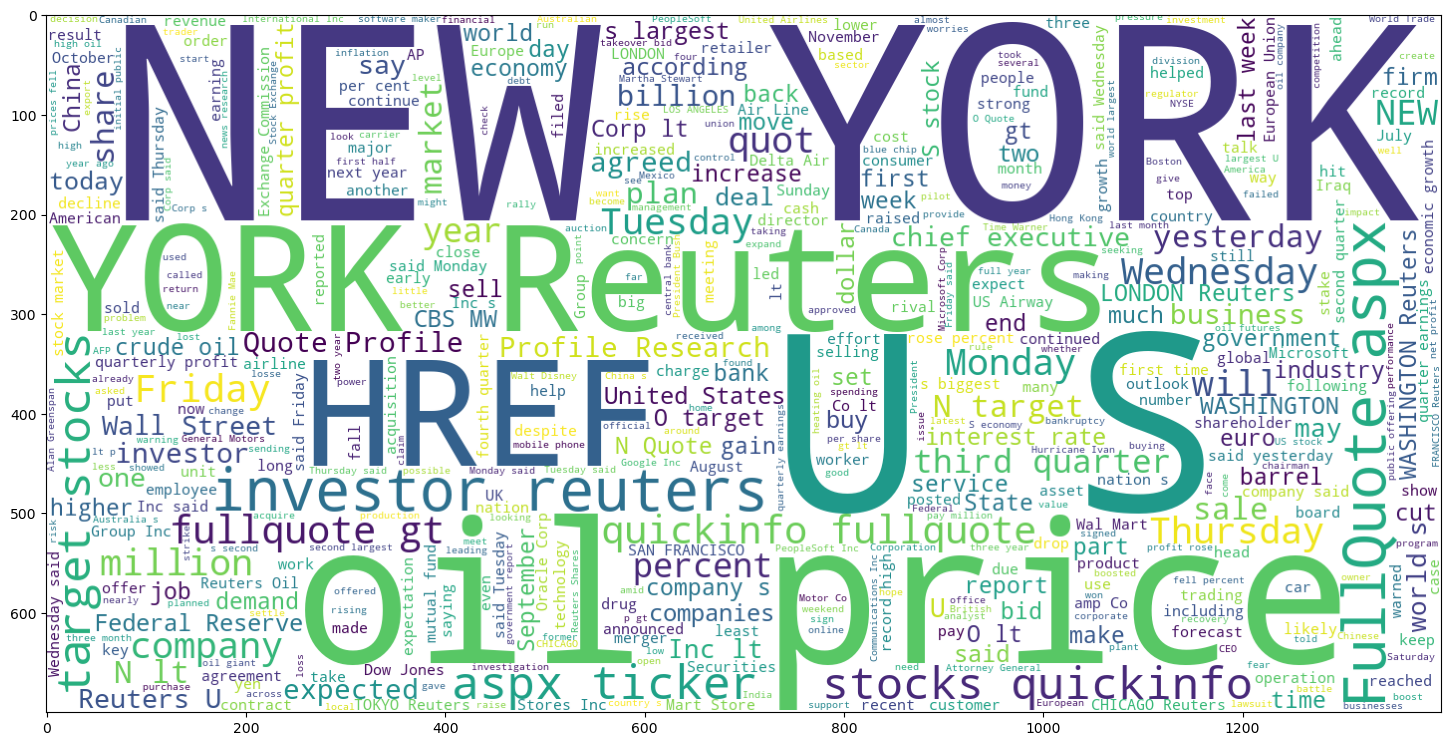

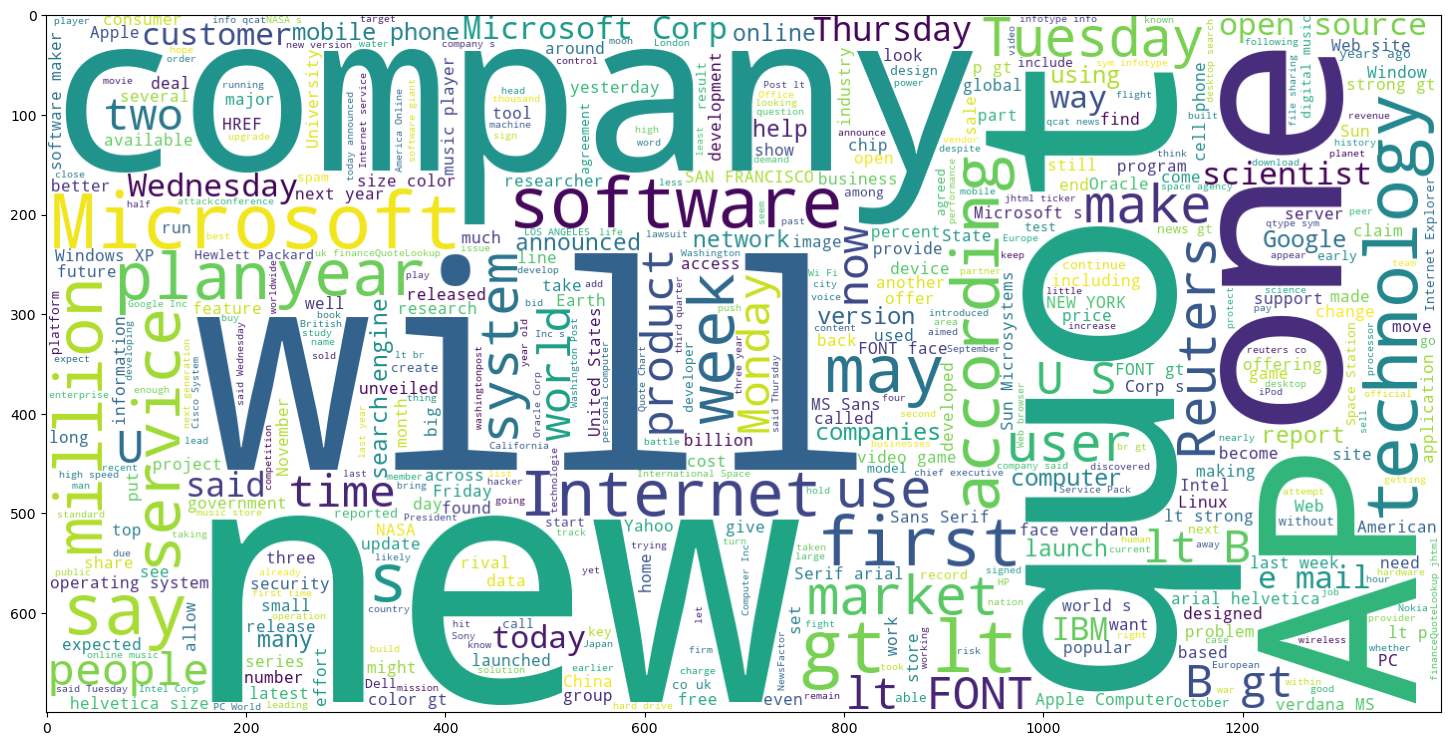

In [10]:
# visualize the train dataset
create_word_cloud(world_news)
create_word_cloud(sports_news)
create_word_cloud(business_news)
create_word_cloud(science_news)

In [11]:
# create a list of words for each class (using the test dataset)
world_news = " ".join(test_data[test_data['Class Index'] == 0]['Description'])
sports_news = " ".join(test_data[test_data['Class Index'] == 1]['Description'])
business_news = " ".join(test_data[test_data['Class Index'] == 2]['Description'])
science_news = " ".join(test_data[test_data["Class Index"] == 3]['Description'])

Word count:  370519
Word count:  351193
Word count:  377778
Word count:  370407


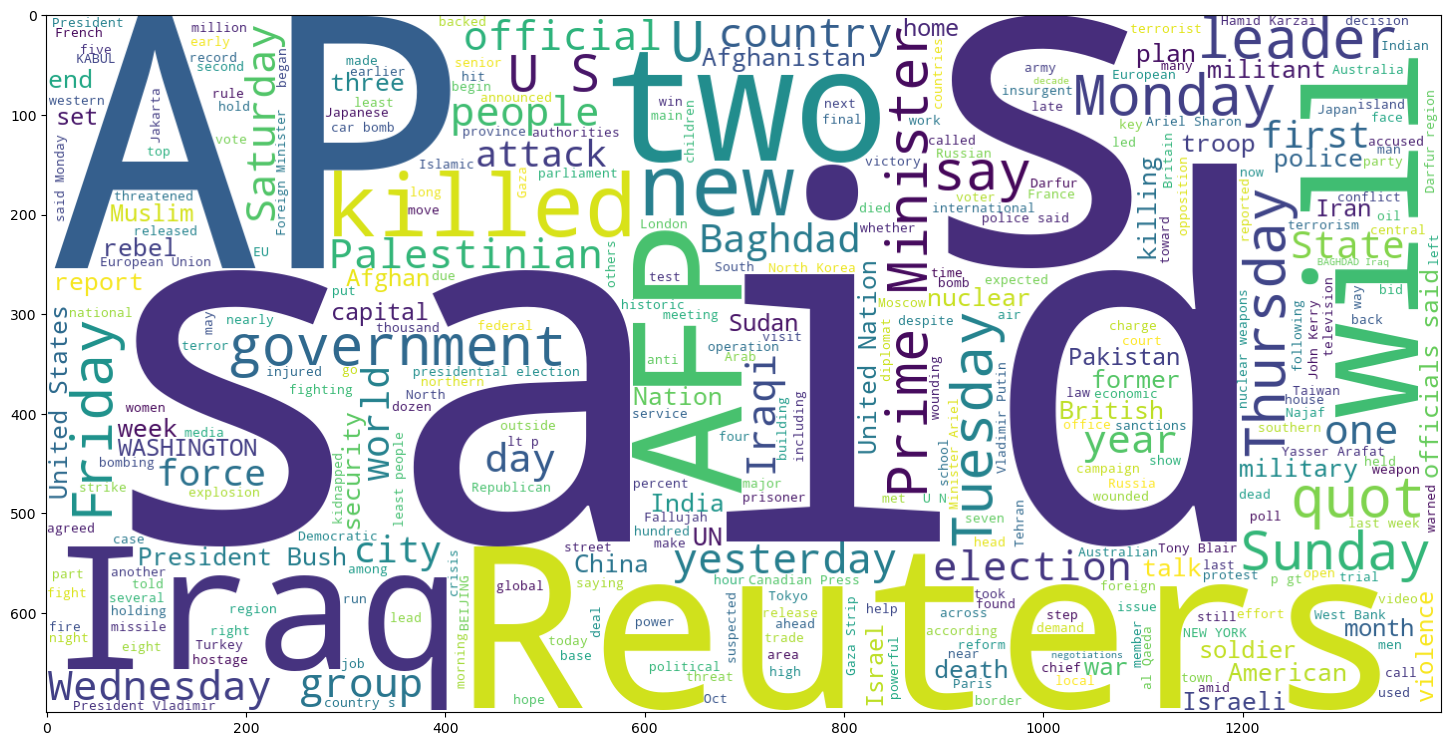

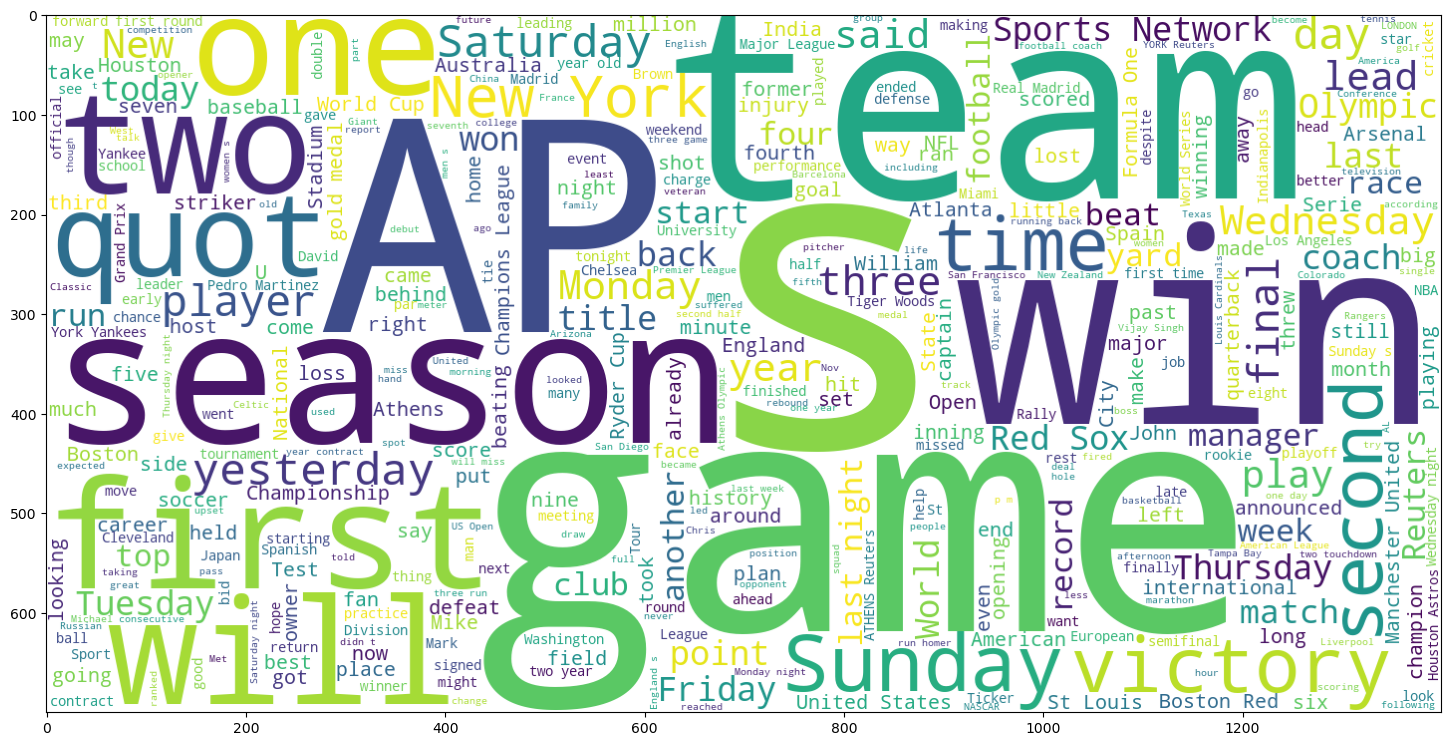

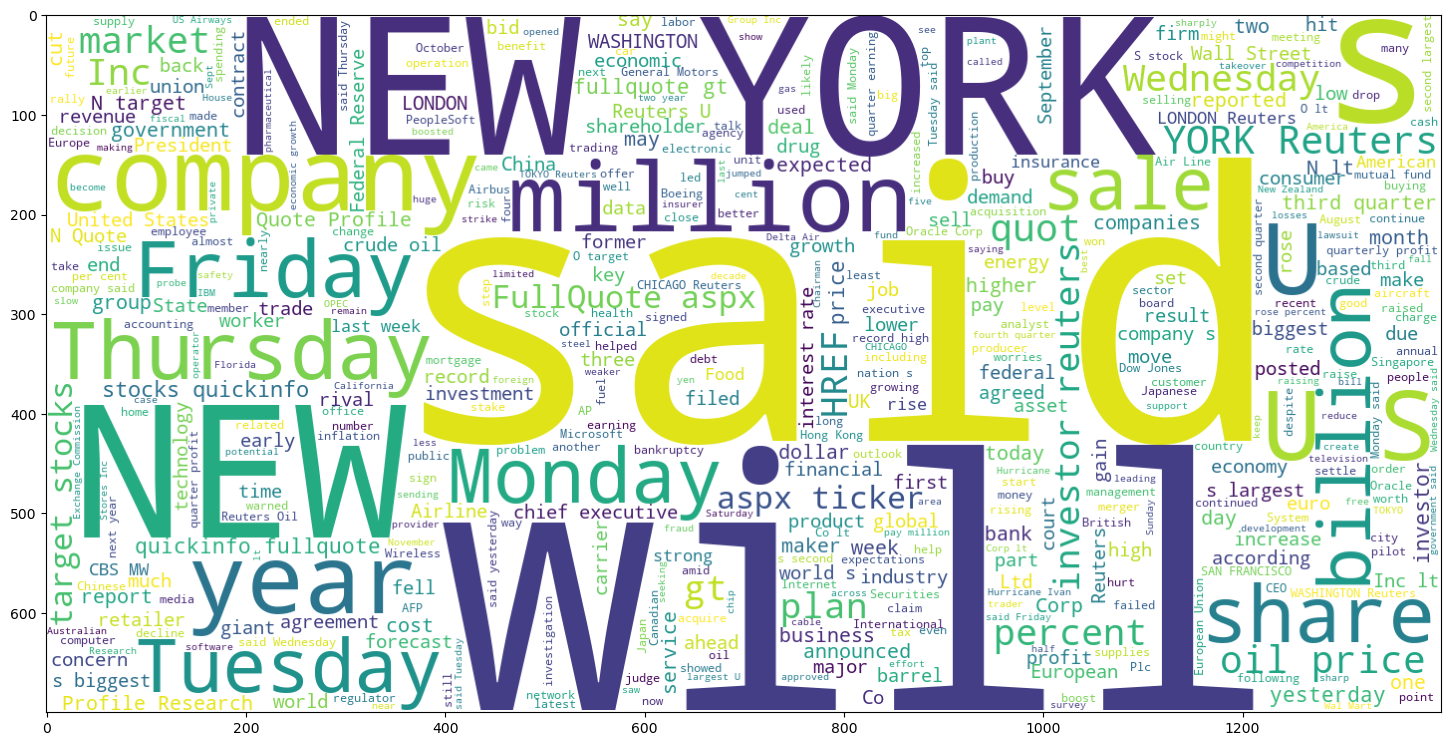

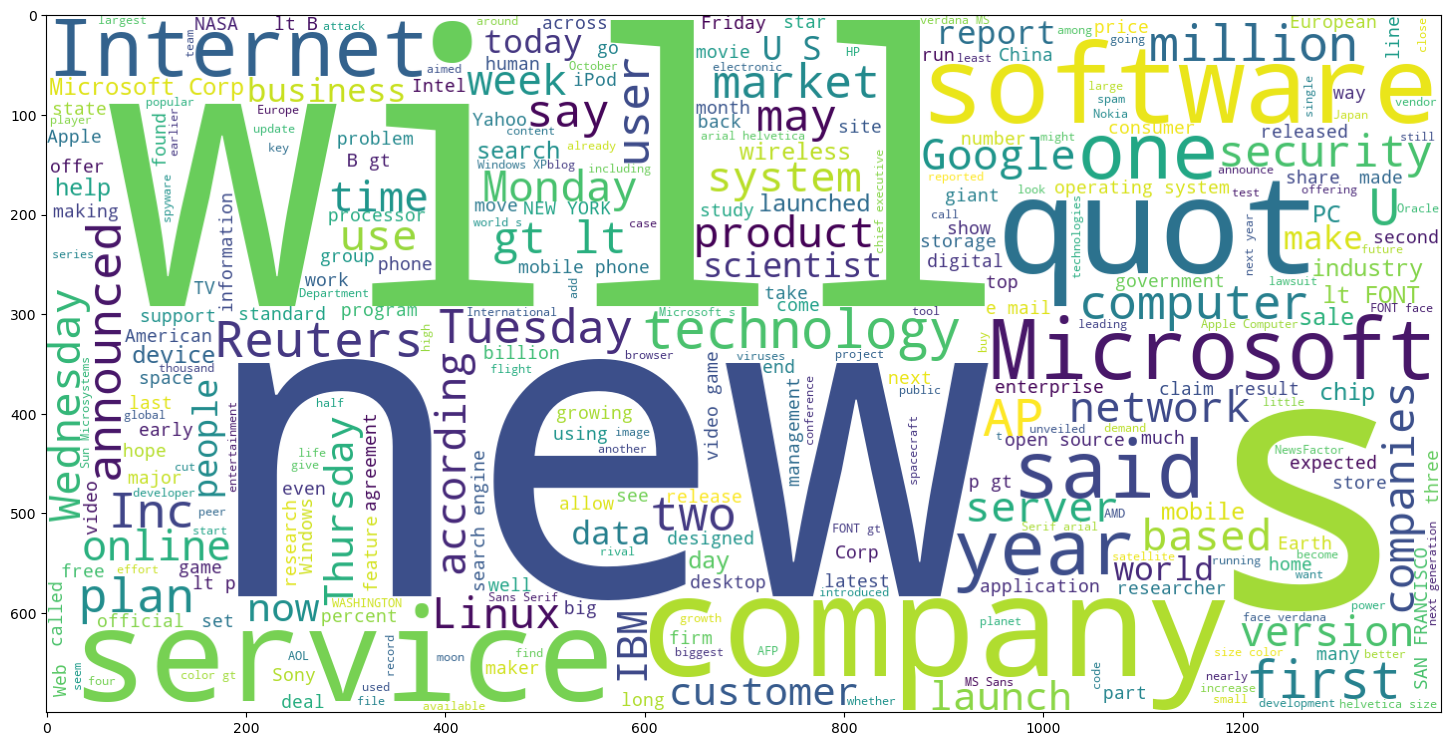

In [12]:
# visualize the test dataset
create_word_cloud(world_news)
create_word_cloud(sports_news)
create_word_cloud(business_news)
create_word_cloud(science_news)

Before we proceed, we will make a bar plot of the data to have an understanding of the class distribution. Although, we have an idea from the word count (shown in the code cell above), it's not a bad idea to have a picturial representation of the class distributions.

<Axes: title={'center': 'Number of samples in each class in training data'}, xlabel='Class Index'>

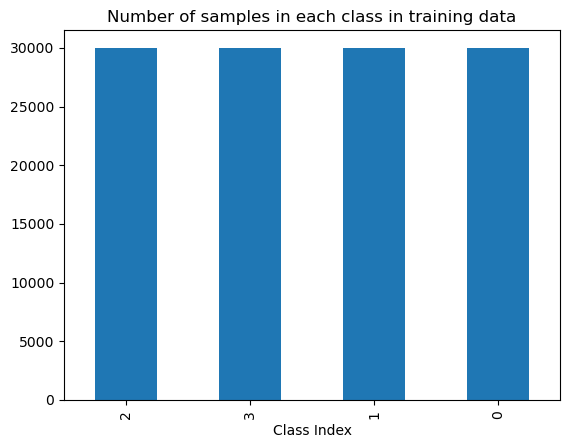

In [20]:
# draw bar plot of train data
train_data['Class Index'].value_counts().plot(
    kind="bar", title="Number of samples in each class in training data"
)

<Axes: title={'center': 'Number of samples in each class in test data'}, xlabel='Class Index'>

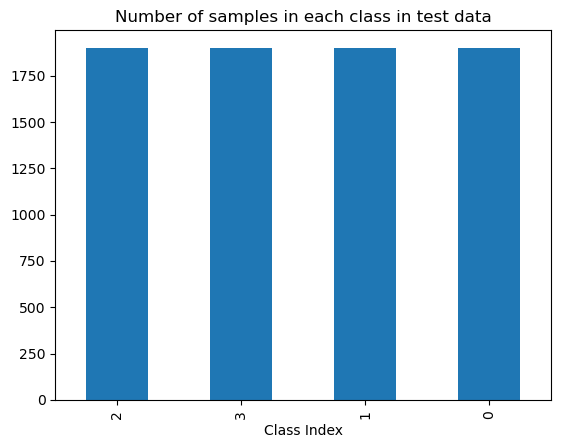

In [21]:
# draw bar plot of test data
test_data['Class Index'].value_counts().plot(
    kind="bar", title="Number of samples in each class in test data"
)

The classes seem evenly distributed so accuracy would be a good metric. 

By looking at some sample entries, we can usually already tell what kind of steps we should start with. 
The following code will show some samples just so that we can have a good overview of the data. You could also use excel or another text editor to do this, but since we are already in a notebook, we will just use python.

In [22]:
# function to show samples of the data
def show_samples(class_index, dataframe):
    """Function to show two samples of each class based on the index (label) and what column to show
    Args:
        class_index (int): class index you want to see the samples from
        dataframe (pd.dataframe): dataframe you want to see the samples from
    """
    print("-----------")
    print("Class Index: ", class_index)
    print("Description 1: ",
           dataframe[dataframe['Class Index'] == class_index]['Description'].iloc[2],)
    print("Description 2: ",
           dataframe[dataframe['Class Index'] == class_index]['Description'].iloc[4],)

Let's see some samples of the training data.

In [23]:
# show samples of training data
show_samples(0, train_data)
show_samples(1, train_data)
show_samples(2, train_data)
show_samples(3, train_data)

-----------
Class Index:  0
Description 1:  thousands of palestinian prisoners in israeli jails began a hunger strike for better conditions sunday  but israel s security minister said he didn t care if they starved to death 
Description 2:  dozens of rwandan soldiers flew into sudan s troubled darfur region sunday  the first foreign armed force deployed in the area since arab militiamen began a rampage against black african farmers  killing thousands 
-----------
Class Index:  1
Description 1:  national basketball association players trying to win a fourth consecutive olympic gold medal for the united states have gotten the wake up call that the  dream team  days are done even if supporters have not 
Description 2:  kevin hartman made seven saves for los angeles  and jon busch had two saves for columbus as the galaxy and crew played to a     tie saturday night 
-----------
Class Index:  2
Description 1:  soaring crude prices plus worries about the economy and the outlook for earnings a

Also, show some samples of the training data.

In [24]:
# show samples of test data
show_samples(0, test_data)
show_samples(1, test_data)
show_samples(2, test_data)
show_samples(3, test_data)

-----------
Class Index:  0
Description 1:  explosions and gunfire rattled through the city of najaf as u s  troops in armored vehicles and tanks rolled back into the streets here sunday  a day after the coll se of talks   and with them a temporary cease fire   intended to end the fighting in this holy city   
Description 2:  supporters and rivals warn of possible fraud  government says chavez s defeat could produce turmoil in world oil market 
-----------
Class Index:  1
Description 1:  with the weeks dwindling until jason varitek enters free agency  the red sox continue to carefully monitor kelly shoppach   their catcher of the future  in his climb toward the majors  the sox like most of what they have seen at triple a pawtucket from shoppach  though it remains highly uncertain whether he can make the adjustments at the plate    
Description 2:  in  quot helping themselves  quot  ricky bryant  chas gessner  michael jennings  and david patten did nothing friday night to make bill beli

# 1. Text Preprocessing 

Simply by looking at the data you can already tell the following: 
- There are a lot of backslashes in the text, which are not really necessary and a lot of punctuation marks.

The steps that you need to take to preprocess the data differ from one dataset to another. It usually helps to look at the data and see what needs to be done:
- If there are special characters, you need to remove them
- If there are numbers, you need to remove them (in most cases)

It also helps to look at the data and see if there are any patterns. For example, in this dataset we have a lot of news articles starting with: "Reuters - " or "AFP - "
We could remove these patterns to make the data cleaner and more useful as those news agencies can indicate the source of the news, although we will not do that in this part of the lab. 
Other techniques that you could try to preprocess the data are **Stemming** and **Lemmatization**, which we have not used here, but will be done in an extension task. 

We therefore create a function that does some kind of preprocessing for us in the code cell below. Remember, we want to use funcitons as we can then reuse the code for the test set as well.

First, we will turn the data to lowercase descriptions and clean up non-letter characters. Next, we will proceed with the following **TO-DO** tasks in order.
- **TO-DO 1**: Remove the occurences of "http" "href", "https" and "www". Also, remove the names of the news agencies (Reuters, AP, ...) from the datasets.
- **TO-DO 2**: Apply stemming or lemmatization to simplify grammatical word variations.

In [25]:
# MODIFIED CODE from Lab 8
# TO-DO 1: function to preprocess the text
def preprocess_text(string):
    """preprocess the text in a string
    Args:
        string (str): string you want to preprocess
    """
    # remove substring after the first dash (if exist within 25 characters)
    if string.find('-', 0, 25) != -1:
        string = string.split("-", 1)[1]

    # remove HTML decoding
    string = BeautifulSoup(string, "lxml").text 

    # lower case the text
    string = string.lower()

    # define forbidden words and replace them with space
    forbidden_words = ["http", "href", "https", "www", "reuters", "ap", "afp"]
    for word in forbidden_words: 
        string = string.replace(word, " ") 

    # replace apostrophe with space
    string = string.replace("'", " ")
    
    # replace backslash with space
    string = string.replace("\\", " ")

    # replace special characters with spaces
    string = re.sub(r"[^a-zA-Z]", " ", string)

    return string

We can then use this function on the dataframes.
In this case, we are applying the *preprocess_text* function to each row of the description column. In the backend, the string value that is saved in the description column is passed to the *preprocess_text* function. Then, since we have the = sign, the return value of the *preprocess_text* function is saved in the description column.

In [26]:
# apply the preprocess_text function to each row of a dataframe
train_data['Description'] = train_data['Description'].apply(preprocess_text)
test_data['Description'] = test_data['Description'].apply(preprocess_text)

Let's show some sample to see how the preprocessed data looks now.

In [27]:
# show samples of train data
show_samples(0, train_data)
show_samples(1, train_data)
show_samples(2, train_data)
show_samples(3, train_data)

-----------
Class Index:  0
Description 1:  thousands of palestinian prisoners in israeli jails began a hunger strike for better conditions sunday  but israel s security minister said he didn t care if they starved to death 
Description 2:  dozens of rwandan soldiers flew into sudan s troubled darfur region sunday  the first foreign armed force deployed in the area since arab militiamen began a rampage against black african farmers  killing thousands 
-----------
Class Index:  1
Description 1:  national basketball association players trying to win a fourth consecutive olympic gold medal for the united states have gotten the wake up call that the  dream team  days are done even if supporters have not 
Description 2:  kevin hartman made seven saves for los angeles  and jon busch had two saves for columbus as the galaxy and crew played to a     tie saturday night 
-----------
Class Index:  2
Description 1:  soaring crude prices plus worries about the economy and the outlook for earnings a

Let's show some sample to see how the preprocessed train data looks as well

In [28]:
# also, show samples of test data
show_samples(0, test_data)
show_samples(1, test_data)
show_samples(2, test_data)
show_samples(3, test_data)

-----------
Class Index:  0
Description 1:  explosions and gunfire rattled through the city of najaf as u s  troops in armored vehicles and tanks rolled back into the streets here sunday  a day after the coll se of talks   and with them a temporary cease fire   intended to end the fighting in this holy city   
Description 2:  supporters and rivals warn of possible fraud  government says chavez s defeat could produce turmoil in world oil market 
-----------
Class Index:  1
Description 1:  with the weeks dwindling until jason varitek enters free agency  the red sox continue to carefully monitor kelly shoppach   their catcher of the future  in his climb toward the majors  the sox like most of what they have seen at triple a pawtucket from shoppach  though it remains highly uncertain whether he can make the adjustments at the plate    
Description 2:  in  quot helping themselves  quot  ricky bryant  chas gessner  michael jennings  and david patten did nothing friday night to make bill beli

#### Text Lemmatization
Next, we create a function to lemmatize the text.

In [29]:
# TO-DO 2: function to lemmatize text
def lemmatize_text(string):
    """tokenizes the words in a text 
    Args:
        string (str): text you want to lemmatize
    """        
    # tokenize the text into words
    words = word_tokenize(string)

    # iinitialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # perform basic text lemmatization 
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the lemmatized words back into a sentence
    string = " ".join(lemmatized_words)

    return string

Similarly, we apply the *lemmatize_text* function on the dataframes.

In this case, we apply the *lemmatize_text* function to each row of the description column. In the backend, the string value that is saved in the description column is passed to the *lemmatize_text* function. Then, since we have the = sign, the return value of the *lemmatize_text* function is saved in the description column.

In [30]:
# apply the lemmatize_text function to each row of a dataframe
train_data['Description'] = train_data['Description'].apply(lemmatize_text)
test_data['Description'] = test_data['Description'].apply(lemmatize_text)

Next, we then convert the data into lists. The reason for this is that quite a few of the next steps require lists as input. Whilst we could use pandas, this would require some more code and would be less efficient. 

In [31]:
# converted the training data into a list
train_data_list = train_data['Description'].tolist()
test_data_list = test_data['Description'].tolist()

# similarly, # converted the training data into a list
train_labels_list = train_data['Class Index'].tolist()
test_labels_list = test_data['Class Index'].tolist()

We can also use a *validation dataset*. This is a sub-dataset used to validate the model during training, *without accessing the test dataset* and is done to prevent overfitting. Recall that overfitting means the model performs well on the training data, but not on the test data. The validation data therefore provides held-out dataset to prevent this.

We can use the `sklearn.model_selection.train_test_split` function to split the training data into training and validation data, similar to what we have done previously with the test data. We use 20% of the training data as validation data and also use stratify to make sure that the distribution of the classes in the training and validation data is the same as in the training data (this is not necessary, but it is good practice). Essentially, this means that the validation data will contain the same number of samples from each class as the training data

In [32]:
# split the data into train, test and validation datasets
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list, train_labels_list, test_size=0.2, stratify=train_labels_list)

#### Removing Stop Words
The Natural Language Tool Kit `nltk` has a lot of *corpora* (datasets) that can be used for different tasks. In this case, we are using the *stopwords* corpus, which contains a list of stop words. For this, we will create a function *remove_stopwords* to remove stop words from the data.

In [33]:
# CODE from Lab 8: function to remove stop words
def remove_stopwords(data_list):
    """removes stopwords from a list of strings by simply checking on a word for word basis if the word is a stopword and if it is, we are removing it

    Args:
        data_list (list): list of strings you want to remove stopwords from
    """

    # get english stop words
    words = stopwords.words("english")

    # run loop to replace stop words with space
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [word for word in data_list[i].split() if word not in (words)]
        )

    return data_list

Next, we use the *remove_stopwords* function to perform text preprocessing step on the train, validation and test data. 

In [34]:
# remove stopwords from the train, test and validation data list
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

# 2. Text Vectorization 

Text vectorization is a technique used to convert the text into a vector representation. Essentially, it is a way to convert text into numbers.

The *TF-ID* vectorizer from *scikit-learn* is a simple implementation of text vectorization that converts texts into a vector representation. This is achieved by using:
- *term frequency (TF)*, the number of times a word appears in a document
- *inverse document frequency (IDF)*, the inverse of the number of documents that contain a word

The TF-IDF vectorizer combines both TF and IDF. This is done by multiplying the term frequency with the inverse document frequency for each word in a document. However, simply calculating those values for the training data does *not* yield vectors directly; we need to call the `.fit` method of the vectorizer to learn the vocabulary and IDF from the training data. After fitting the vectorizer, we can transform the data lists into vectors. This is done by using the `transform()` function. The function returns a sparse matrix which contains the TF-IDF values for each word in the vocabulary that has been found in the specific data sample. 

TF-IDF vectorizer is a very common way to convert text into a vector representation, with other approaches being:
- *Word2Vec*. Very powerful NN-based approach. It passes the word through a neural network that outputs the vector representation of the word
- *Bag of words*. Very simple approach, it just counts the number of times a word appears in a document and uses that as the vector representation of the word
- Other vectorizers can be found here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text.

However, for this report, we will use the *TextVectorization*. More on this [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [35]:
# set the vocabulary size to the top 2500 words 
vocab_size = 2500 

# word count representing a description
sequence_length = 30 

# convert the text to a sequence of numbers
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)

# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(train_data_list)

# show the selected words
print(vectorizer.get_vocabulary())

['', '[UNK]', 'said', 'ha', 'u', 'new', 'wa', 'year', 'company', 'two', 'quot', 'first', 'wednesday', 'monday', 'one', 'tuesday', 'world', 'thursday', 'friday', 'inc', 'week', 'game', 'state', 'last', 'yesterday', 'time', 'million', 'president', 'day', 'three', 'corp', 'oil', 'stock', 'price', 'say', 'sunday', 'government', 'month', 'would', 'united', 'people', 'official', 'group', 'today', 'service', 'second', 'c', 'security', 'could', 'n', 'team', 'percent', 'saturday', 'season', 'night', 'software', 'plan', 'next', 'third', 'market', 'minister', 'iraq', 'quarter', 'business', 'country', 'fullquote', 'microsoft', 'internet', 'investor', 'high', 'announced', 'billion', 'back', 'report', 'computer', 'com', 'american', 'international', 'four', 'technology', 'system', 'win', 'may', 'share', 'sale', 'top', 'leader', 'record', 'home', 'network', 'former', 'news', 'city', 'york', 'j', 'victory', 'end', 'election', 'nation', 'player', 'maker', 'giant', 'open', 'european', 'co', 'largest', 'l

In [36]:
# vectorize the training data (replace words by their associated values)
train_data_vectorized = vectorizer(train_data_list)

# vectorize the validation data (replace words by their associated values)
validation_data_vectorized = vectorizer(validation_data_list)

# vectorize the test data (replace words by their associated values)
test_data_vectorized = vectorizer(test_data_list)

# show the shape of vectorized data
print(train_data_vectorized.shape)
print(validation_data_vectorized.shape)
print(test_data_vectorized.shape)

(96000, 30)
(24000, 30)
(7600, 30)


# 3. Model Architectures

Before setting up the model architectures, there are some extra steps that we need to take to get the data in the right format for the neural network. First, we will  need to convert the label indices to one-hot encoded vectors (Example [2] --> [0,0,1,0]). Scikit-learn does this in the background but for using keras, we need to use  the to_categorical() function from the keras.utils module. We then also need to turn the vectorized data into a format, that is compatible with tensorflow/keras. This generates a numpy array. 

In [37]:
# our target label consist of values 0, 1, 2, 3. we need to convert them to one-hot encoded vectors 
train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)

# preview the data structure
print(train_labels.shape, validation_labels.shape, test_labels.shape)

(96000, 4) (24000, 4) (7600, 4)


#### Recurrent Neural Network (RNN)

Recurrent neural networks (RNN) are networks that are used for sequential data. They can be very useful for NLP tasks, as they can take into account the order of the words in a sentence. Due to the way the layers are built, they have the ability to remember information from previous inputs. This aids them in understanding the context of the sentence.

Hence, we will use an *Embedding layer* to convert the integer sequences to embeddings. More on this [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this, we will use the *TextVectorization* object. More on this [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization). We will also add a *Bidirectional* layer takes the input and passes it forwards and backwards through the *LSTM (Long-Short Term Memory)* layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          80000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 96,900
Trainable params: 96,900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
750/750 [==============================] - 23s 26ms/step - loss: 0.4819 - accuracy: 0.8214 - val_loss: 0.3490 - val_accuracy: 0.8798
Epoch 2/5
750/750 [==============================] - 18s 24ms/step - loss: 0.3272 - accuracy: 0.8875 - val_

<Axes: >

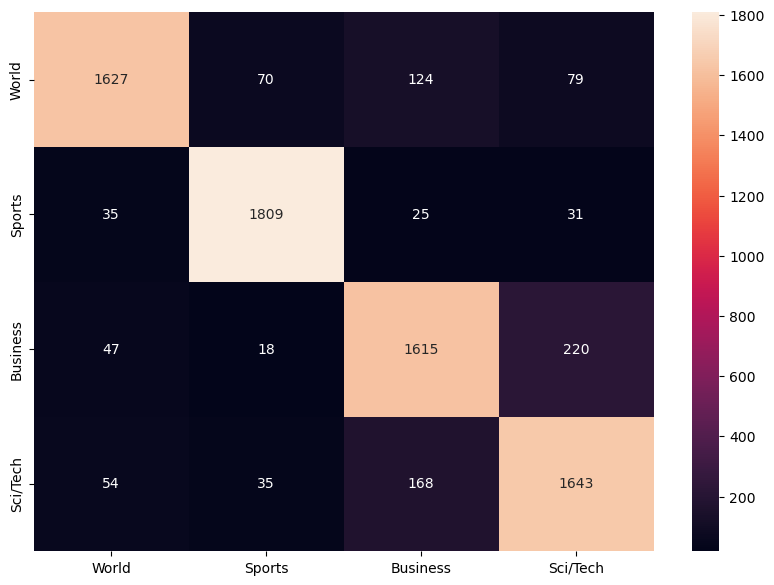

In [38]:
# setup the RNN model
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

# show model summary
model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized,)

# since predictions are one-hot encoded, we convert them to an int64 labels taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("Test Set Accuracy: ", accuracy)

# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)

# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

##### TO-DO 3: Creating Example Predictions
To test the RNN model, we will create some fresh sample news (using one example per class from news site like BBC) to see if the model can predict the correct labels. We will include a false sample from each class to see if it gets misclassified by the models.

In [39]:
# create a news list  
sample_news = list()

# TODO 3: create some fresh sample news (copy them from a news site like BBC)
sample_news.append("There’s been increased cross-border fighting between Israel and the Lebanese armed group Hezbollah since the Hamas attacks on 7 October. But rocket fire and the use of weaponised drones by Hezbollah has escalated further this week, and Israel has responded. An Israeli war cabinet minister, Benny Gantz, warned that if the world and the Lebanese government didn’t act to stop the attacks, then the Israel Defense Forces (IDF) would take matters into its own hands. In Gaza, as IDF troops have pushed into the central urban refugee camps and continue to target Hamas in Khan Younis in the south, tens of thousands of people have been fleeing.")
sample_news.append("Managers Pep Guardiola and Sean Dyche experienced differing emotions at Goodison Park on Wednesday - but both left the ground questioning the laws of football. Manchester City defender John Stones limped off with an ankle injury sustained after the assistant referee had kept his flag down as Beto ran through on goal despite being offside. And then, in the second half, Everton felt harshly done by after seeing a penalty awarded against them for Amadou Onana's handball from Nathan Ake's shot. It allowed Julian Alvarez to convert from the spot, with goals from Phil Foden and Bernardo Silva either side giving the visitors a 3-1 victory.")
sample_news.append("UK sales of vinyl LPs have hit their highest level since 1990 as the revival of the physical music market continues. Sales rose by 11.7% to 5.9 million units, increasing for the 16th year in a row, according to the British Phonographic Industry (BPI) trade group. Taylor Swift's 1989 (Taylor's Version) was the best-selling LP, followed by the Rolling Stones' Hackney Diamonds. Cassette sales also did well, topping 100,000 for a fourth consecutive year. While more than four-fifths of recorded music is consumed via streaming, vinyl has made a huge comeback, with fans seeing it as more collectible and having better sound quality.")
sample_news.append("The company which became well known for its idea of shooting people hundreds of miles an hour through a vacuum has shut down. The aim of Hyperloop One, based on an idea by Elon Musk, was to dramatically cut journey times. It has previously received backing from Virgin founder Richard Branson, but he pulled out last year. The firm will lay off its remaining staff by the end of the year, according to Bloomberg. The company had promised a new era of high speed travel, using magnetic levitation (maglev) technology - which is already used in some transport systems - within a vacuum tube. This would reduce friction and air resistance, allowing the train to travel at speeds of 700mph (1,127km/h).")

# also, include a false sample here (in this example, we included a weather news)
sample_news.append("Why is it hard to forecast snow in the UK? Why is forecasting snow in the UK tricky? Why is it hard to forecast snow in the UK? There are lots of variables that affect when snow will fall in the UK, such as the sea and air temperature, the amount of rain in the atmosphere and the basic geographical position.")

# preprocess the sample news
sample_news = [preprocess_text(i) for i in sample_news] 

# lemmatize the sample news
sample_news = [lemmatize_text(i) for i in sample_news]

# remove stop words from the sample news
sample_news = remove_stopwords(sample_news)

# vectorize the sample news
sample_news_vectorized = vectorizer(sample_news)

# predict using the neural network
prediction = model.predict(sample_news_vectorized)
prediction = np.argmax(prediction, axis=1)
for i in prediction:
     print("RNN classifier prediction: ", label_names[prediction[i]], "News")


1/1 [==============================] - 0s 35ms/step
RNN classifier prediction:  World News
RNN classifier prediction:  Sports News
RNN classifier prediction:  Business News
RNN classifier prediction:  Sci/Tech News
RNN classifier prediction:  Business News


#### Fully Connected Neural Networks (CNN)

In an attempt to improve the accuracy of the RNN models above, we will implement a fully Connected Neural Network (CNN) (with 1D convolution layers). The CNN will be applied on the same data as the RNN classifiers, so we can compare the results of models. The network here is a simple 5 *Dense* layer, fully connected, architecture (1 input, 3 hidden and 1 output layer). We use the *ReLu* activation function for the hidden layers. *Softmax* activation is used for output layer as we are trying to predict a single class out of multiple. Also, we will add an *Embedding* layer that considers the complete vocabulary with a sequence length of 30 words.

30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 4)             10000     
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                7744      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 4)             

<Axes: >

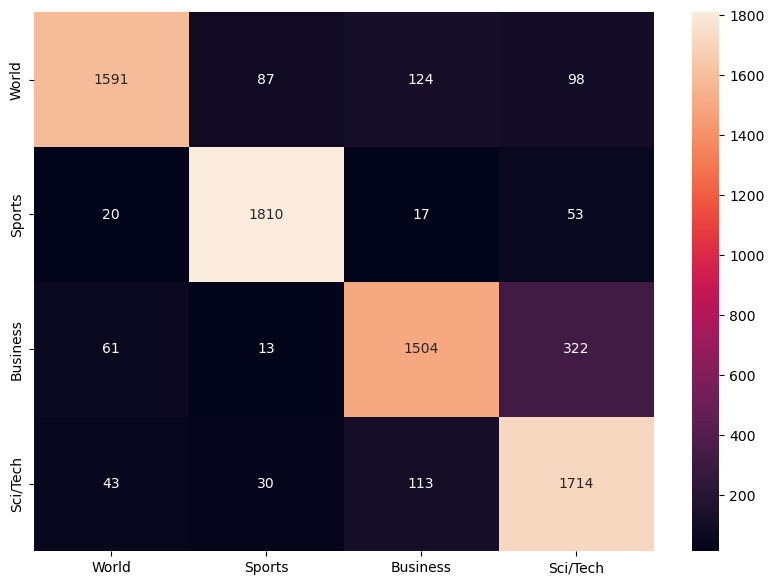

In [40]:
# confirm the data structure
num_features = train_data_vectorized.shape[1]
print(num_features)

# setup the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=4, input_length=sequence_length))
model.add(Flatten())
model.add(Dense(64, activation="relu", input_shape=(num_features,)))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(4, activation="softmax"))

# print the model summary
model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# we are using the validation data to evaluate the model, after each epoch.
# this is useful to check if the model is overfitting
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
cnn_predictions = model.predict(test_data_vectorized)

# convert one-hot encoded labels to single labels ([0,0,1,0] -> 2)
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, cnn_predictions)
print("Test Set Accuracy: ", accuracy)

# create a confusion matrix
cm = confusion_matrix(test_labels_list, cnn_predictions)

# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

#### Model Comparison

Now let us compare the performance of all the models.

To do this, we will simply compare the classification report of both models.

In [41]:
# accuracy and classification report for RNN
print('Accuracy %s' % accuracy_score(rnn_predictions, test_labels_list), '\n')
print(classification_report(test_labels_list, rnn_predictions, target_names=label_names))

print(20*"-"+ "***************" + 20*"-", '\n')

# accuracy and classification report for CNN
print('Accuracy %s' % accuracy_score(cnn_predictions, test_labels_list), '\n')
print(classification_report(test_labels_list, cnn_predictions, target_names=label_names))

Accuracy 0.8807894736842106 

              precision    recall  f1-score   support

       World       0.92      0.86      0.89      1900
      Sports       0.94      0.95      0.94      1900
    Business       0.84      0.85      0.84      1900
    Sci/Tech       0.83      0.86      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

--------------------***************-------------------- 

Accuracy 0.8709210526315789 

              precision    recall  f1-score   support

       World       0.93      0.84      0.88      1900
      Sports       0.93      0.95      0.94      1900
    Business       0.86      0.79      0.82      1900
    Sci/Tech       0.78      0.90      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



# 4. Discussion

When comparing result of the two (2) models, we can see that the RNN performs the best (88% for RNN, compared with 87% for CNN). This is because it does not only take into account the sequential nature of the data and the context of the sentence, which the CNN model also does, but also adds a bidirectional layer that takes the input and passes it forwards and backwards through the LSTM layer. By doing so, information from both the past and the future (that is, the context of the previous words, and following words in the text) is taken into account. 

Although the CNN model still performed well, this is a good example that proves neural networks can be generally very useful for natural lanuague processing tasks. However, you will notice, that the results are not that far apart from each other. This is because the dataset is relatively small and the models are not very complex.

In addition, the following steps were taken to clean and preprocess the data, even though these steps was applied to both model architectures, giving them a slight performance boost.
- Removing the occurrences of residual html code (“http", "href", "https", "www", “quot”, “lt”, …) from the datasets which indicate weblinks. Also, remove the news agencies names (“Reuters”, “AP”, …).
- Applying text lemmatization to simplify grammatical word variations.

--- 
REFERENCES

Sources:
- Google ML Guides (Text Classification): https://developers.google.com/machine-learning/guides/text-classification
- Understanding Text Classification in Python: https://www.datacamp.com/tutorial/text-classification-python
- TensorFlow Text Vectorization: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
- TensorFlow Embedding Layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

---